In [1]:
import os
import sys
from pathlib import Path
import argparse
import yaml
import math
import numpy as np
import json
import shutil
import PIL
from PIL import Image
import requests

import torch
import torchvision.transforms as T
import torch.nn as nn
from torchvision.transforms.functional import to_tensor, to_pil_image


current_path = os.getcwd()
base_path = os.path.dirname(current_path)

sys.path.append(base_path)

import customconfig
from metrics.eval_detr_metrics import eval_detr_metrics
from experiment import ExperimentWrappper
from inference import DeepFashionDataset
from models.backbone import build_backbone
from models.transformer import build_transformer
from models.garment_detr_2d import GarmentDETRv6


/home/yuki/learn-computer-vision/SewFactory/packages
/home/yuki/learn-computer-vision/SewFactory/packages


In [2]:
def is_img_file(fn):
    img_endfix = ["png", "PNG", "jpg", "jpeg", "jpg", "JPEG", "JPG"]
    return fn.split(".")[-1] in img_endfix


def load_source_appearance(img_fn):
    ref_img = PIL.Image.open(img_fn).convert("RGB")
    h, w = ref_img.size
    min_size, max_size = min(h, w), max(h, w)
    pad_ref_img = T.Pad(
        padding=(int((max_size - h) / 2), int((max_size - w) / 2)), fill=255
    )(ref_img)
    img_tensor = T.Compose([T.Resize((384, 384)), T.ToTensor()])(pad_ref_img)
    return img_tensor.unsqueeze(0), img_fn

img_transform = T.Compose([T.Resize((384, 384)), T.ToTensor()])

In [3]:
config_file_path = "../configs/test.yaml"
test_type = "deepfashion"
save_root = "../outputs/deepfashion/"

with open(config_file_path, "r") as f:
    config = yaml.safe_load(f)

In [4]:
config["experiment"][
    "local_dir"
] = "../garment_outputs/Detr2d-V6-final-dif-ce-focal-schd-agp"
config["dataset"][
    "panel_classification"
] = "../assets/data_configs/panel_classes_condenced.json"
config["dataset"]["filter_by_params"] = "../assets/data_configs/param_filter.json"
config["NN"][
    "pre-trained"
] = "../assets/ckpts/Detr2d-V6-final-dif-ce-focal-schd-agp_checkpoint_37.pth"

In [5]:
shape_experiment = ExperimentWrappper(config, wandb_username="")
shape_dataset, shape_datawrapper = shape_experiment.load_detr_dataset(
    [],  # assuming dataset root structure
    {
        "feature_caching": False,
        "gt_caching": False,
    },  # NOTE: one can change some data configuration for evaluation purposes here!
    unseen=True,
    batch_size=1,
)

shape_model, criterion, device = shape_experiment.load_detr_model(
    shape_dataset.config, others=False
)

ExperimentWrappper::Warning::Skipping loading split file from cloud..
ExperimentWrappper::Warning::Skipping loading panel classes file from cloud..
ExperimentWrappper::Warning::Skipping loading parameter filter file from cloud..
[]
GarmentDetrDataset::Info::Collecting all datasets (no sub-folders) to use
listdir: path should be string, bytes, os.PathLike, integer or None, not list
GarmentDetrDataset::Info::Total valid datanames is 0
GarmentDetrDataset::Info::Storing datapoints ground_truth info in memory
255
No Test set, Stop


/home/yuki/anaconda3/envs/sewformer-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yuki/anaconda3/envs/sewformer-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ExperimentWrappper::Info::Loading locally saved model
../assets/ckpts/Detr2d-V6-final-dif-ce-focal-schd-agp_checkpoint_37.pth


In [6]:
num_classes = config["dataset"]["max_pattern_len"]  # 23
backbone = backbone = build_backbone(config)
panel_transformer = build_transformer(config)
model = GarmentDETRv6(
    backbone, panel_transformer, num_classes, 14, 22, edge_kwargs=config["NN"]
)

In [7]:
model = nn.DataParallel(model, device_ids=['cuda:0'])
model.load_state_dict(torch.load(config["NN"]["pre-trained"])["model_state_dict"])

<All keys matched successfully>

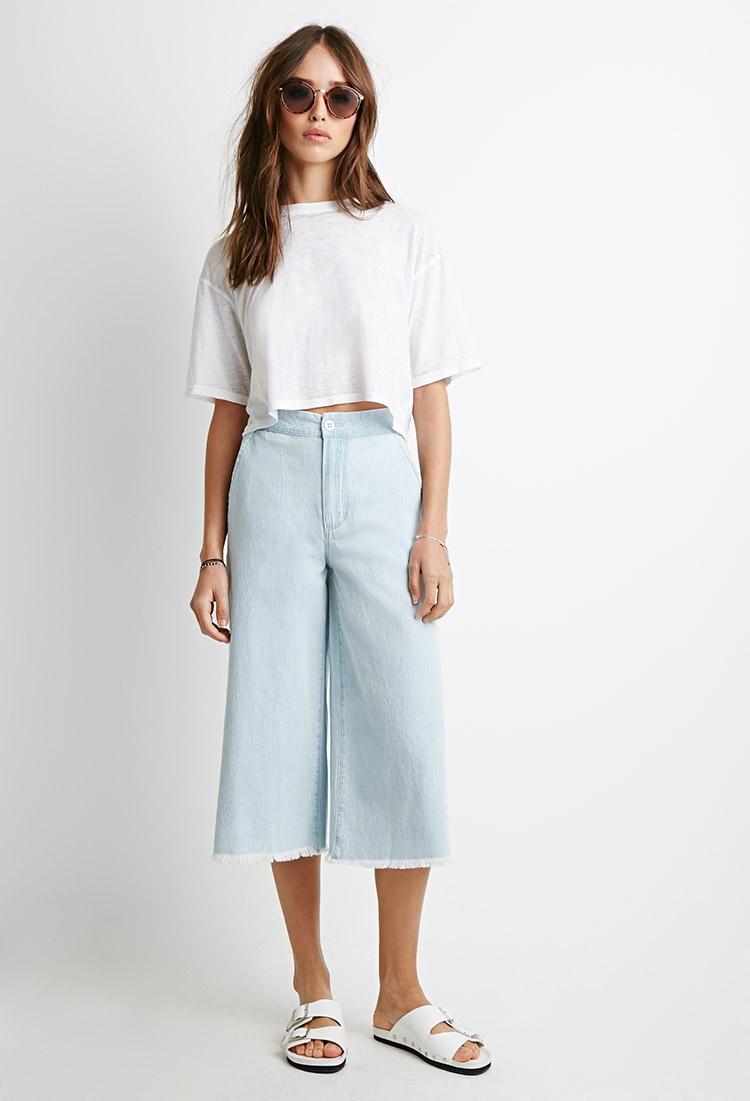

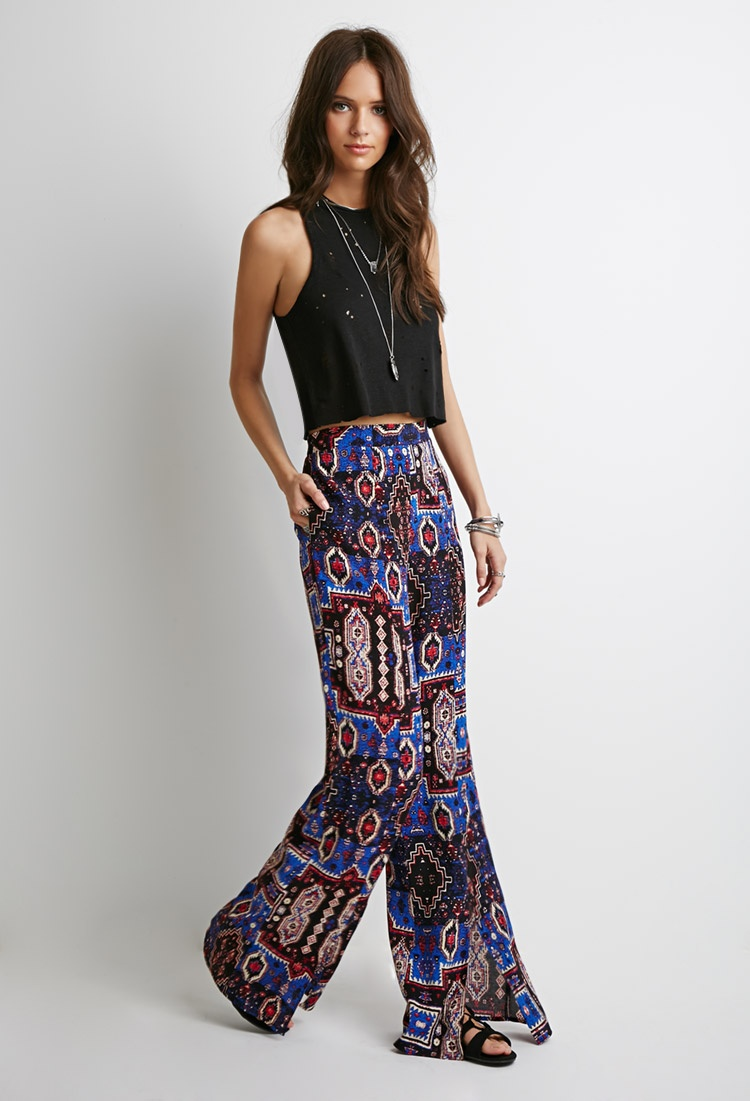

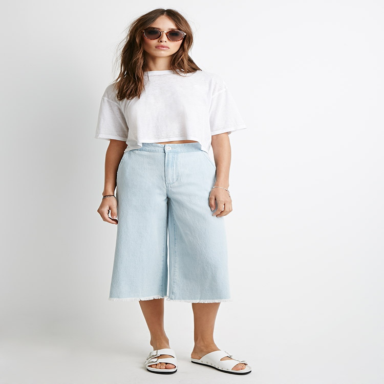

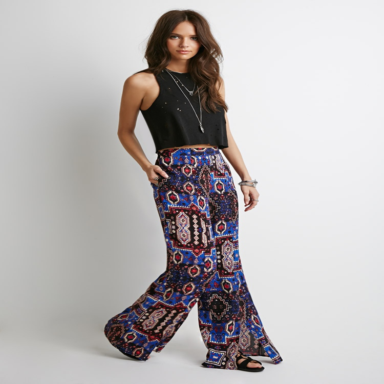

In [8]:
input_image_path_1 = '../assets/data/deepfashion/WOMEN-Pants-id_00001944-01_1_front.jpg'
image_1 = Image.open(input_image_path_1)
display(image_1)

input_image_path_2 = '../assets/data/deepfashion/WOMEN-Pants-id_00007458-02_1_front.jpg'
image_2 = Image.open(input_image_path_2)
display(image_2)

img_tensor_1 = img_transform(image_1).unsqueeze(0)
display(to_pil_image(img_tensor_1[0]))
img_tensor_2 = img_transform(image_2).unsqueeze(0)
display(to_pil_image(img_tensor_2[0]))

In [9]:
# predict the pattern of the two images at the same time

# img_tensor = torch.cat([img_tensor_1, img_tensor_2], dim=0)
# print(img_tensor.shape)
# output = model(img_tensor)

In [10]:
output_1 = model(img_tensor_1, output_panel_memory=True)
print(output_1['panel_memory'].shape)

<class 'torch.Tensor'>
torch.Size([576, 1, 256])
torch.Size([1, 256, 24, 24])


In [11]:
output_2 = model(img_tensor_2, output_panel_memory=True)
print(output_2['panel_memory'].shape)

<class 'torch.Tensor'>
torch.Size([576, 1, 256])
torch.Size([1, 256, 24, 24])


In [12]:
panel_memory_1 = output_1['panel_memory']
bs, c, h, w = panel_memory_1.shape
panel_memory_1 = panel_memory_1.view(bs, c, -1).permute(2, 0, 1)

panel_memory_2 = output_2['panel_memory']
bs, c, h, w = panel_memory_2.shape
panel_memory_2 = panel_memory_2.view(bs, c, -1).permute(2, 0, 1)

panel_memory_interpolation = (panel_memory_1 + panel_memory_2) / 2

output = model(img_tensor_1, panel_memory=panel_memory_interpolation)

In [18]:
interpolation_num = 5
for i in range(interpolation_num+1):
  panel_memory_interpolation = panel_memory_1 * ((5-i) / 5) + panel_memory_2 * (i / 5)
  output = model(img_tensor_1, panel_memory=panel_memory_interpolation)
  dataname = f'tmp{i}'
  save_to = '../outputs/interpolation/'
  _, _, prediction_img = shape_dataset.save_prediction_single(output, dataname, save_to, return_stitches=False)